In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize

In [3]:
def stringlength_norm(m, norm="default"):
    """
    Normalize string length data set.
    
    Parameters
    ----------
    m : array
        Data array
    norm : string, {default, no}
        If 'default' (default), the data points (mi) will be renormalized according
        to Eq. 3 in Dworetsky 1983, i.e., using mnew = (mi - min(m)) / (2*(max(m) - min(m))).
        If 'no' is specified, the data will not be changed.
    
    Returns
    -------
    ms : array
        The normalized data
    """
    if norm == "default":
        mmin = np.min(m)
        mmax = np.max(m)
        # Dworetsky 1983, Eq. 3
        ms = (m-mmin) / (2 * (mmax-mmin)) - 0.25
    elif norm is False:
        # Do nothing wrt normalization
        ms = m
    else:
        raise ValueError("Unknown value for 'norm': " + str(norm), \
                             where="stringlength_norm", \
                             solution="Use 'default' or False")
    return ms



def string_length(x,y, closed=False):
    """String length of a light curve
    from https://github.com/sczesla/PyAstronomy/blob/master/src/pyTiming/stringlength.py

    Parameters
    ----------
    x : np.array
        Values on the x-axis, probably time. Should be normalized to run between 0-1.
    y : np.array
        Values on the y-axis, probably mags. Probably should be normalized with
        stringlength_norm first. 
    closed : bool
        Should the final point connect back to the first, i.e., this is 
        a periodic source. Default True.
    """
    # String length
    sl = np.sum(np.sqrt( np.diff(x)**2 + np.diff(y)**2 ))
    if closed:
        sl += np.sqrt( (x[0] - x[-1] + 1)**2 + (y[0] - y[-1])**2 )
    return sl

class VarStar(object):
    """Variable star object. Loads up a light curve and then has methods for
    various analysis of the star.
    """
    def __init__(self, mags, times, filter_names):
        self.mags = mags
        self.times = times
        self.filter_names = filter_names
        
    def string_length(self, period_try, filters="all"):
        """Compute the string length of the star for a given period.
        Computes and sums over each filter.
        """

        if filters == "all":
            filters = np.unique(self.filter_names)

        result = 0
        for filtername in filters:
            in_filt = np.where(self.filter_names == filtername)[0]
            t = self.times[in_filt] % np.abs(period_try)
            # Phased time between 0-1
            t = t/period_try
            ord_indx = np.argsort(t)
            mags_norm = stringlength_norm(self.mags[in_filt][ord_indx])
            result += string_length(t[ord_indx], mags_norm)

        return result

    def min_sl(self, x0=None, x0_min=0, x0_max=100, x0_step=0.5, 
               method='Nelder-Mead', tol=1e-6,**kwargs):
        """Try to minimize string length, store the 
        best fit result. 
        """

        if x0 is None:
            x0s = np.arange(x0_min, x0_max, x0_step)
        else:
            x0s = [x0]

        result = None
        for x0 in x0s:
            res = minimize(self.string_length, x0, method=method, tol=tol, **kwargs)
            if result is None:
                result = res
            else:
                if res.fun < result.fun:
                    result = res
            
        self.minsl_result = result

    
        

In [9]:
t = np.arange(50)
mags = np.sin(t/10. * 2 * np.pi) + np.random.rand(50)*.05
filters=np.array(["r"] * 50)
vs = VarStar(mags, t, filters)

In [13]:
vs.min_sl(x0_min=0.1, x0_max=50)

In [14]:
vs.minsl_result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.4465208190573235
             x: [ 9.968e+00]
           nit: 20
          nfev: 40
 final_simplex: (array([[ 9.968e+00],
                       [ 9.968e+00]]), array([ 1.447e+00,  1.447e+00]))

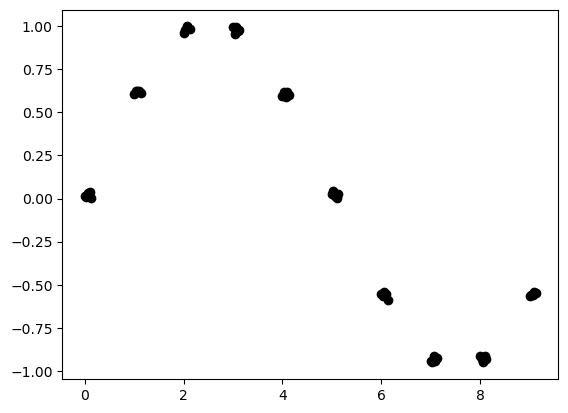

In [15]:
plt.plot(t % vs.minsl_result.x, mags, 'ko')